Necessary imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

The ML estimator for the mean is $ \frac{1}{N}\sum_{i=1}^{N}x_i $. It's always unbiased, as $ \mathbb{E} [\overline{x}]=\mathbb{E}[\frac{1}{N}\sum_{i=1}^{N}x_i]=\frac{1}{N}\mathbb{E}[\sum_{i=1}^{N}x_i]=\frac{1}{N}N \mathbb{E}[x]=\mu$

In [2]:
def compute_mle_mu(X:np.ndarray):
    mu=X.mean(axis=0)
    return mu

The biased ML estimator for the covariance is $ \Sigma=\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})(x_i - \overline{x})^T $, while the unbiased ML estimator is $ \Sigma=\frac{1}{N-1}\sum_{i=1}^{N}(x_i - \overline{x})(x_i - \overline{x})^T $

In [3]:
def compute_mle_sigma(X:np.ndarray, biased=False):
    '''
    :param X: multidimensional data as numpy-matrix
    :param biased: Whether to use unbiased function or not
    :return:
    '''
    mu=X.mean(axis=0)
    n=X.shape[0]
    col=X.shape[1]
    mle_sigma=np.zeros([col,col])
    if biased:
        # computing biased MLE for sigma
        for x in range(col):
            for y in range(col):
                mle_sigma[x][y]=1/n*np.sum((np.stack(X,1)[x]-mu[x])*(np.stack(X,1)[y]-mu[y]).T,0)
    else:
        # computing unbiased MLE for sigma
        for x in range(col):
            for y in range(col):
                mle_sigma[x][y]=1/(n-1)  *np.sum((np.stack(X,1)[x]-mu[x])*(np.stack(X,1)[y]-mu[y]).T,0)
    return mle_sigma

The log-likelihood is $ \ln{\mathcal{N}(\bf{x};\mu,\bf{\Sigma})}=-\frac{D}{2}\ln{2\pi}-\frac{1}{2}\ln{\det \bf{\Sigma}}-\frac{1}{2}(\textbf{x}-\mu)^T \bf{\Sigma^{-1}}(\bf{x}-\mu)$:

In [4]:
def compute_log_likelihood(x,sigma,mu):
    sigma_diag=np.diagonal(sigma)
    f1=np.dot((x - mu).T,np.linalg.inv(sigma))
    f2=np.dot(f1,(x-mu))

    return -np.log(np.linalg.det(sigma)) - 0.5 * f2

This equation for log-likelihood can be simplfied to make the computation more efficient by applying the independency assumption between the variables in Naive Bayes: $ -\sum_{i=1}^D \ln{\sigma_i}-\frac{1}{2}\sum_{i=1}^D(\frac{x_i - \mu_i}{\sigma_i})^2$:

In [5]:
def compute_log_likelihood_optim(x,sigma,mu):
    d=2
    
    f2=np.sum((x-mu)**2/np.diag(sigma),axis=1)

    return -np.log((2*np.pi)**(d/2)*np.prod(np.sqrt(np.diag(sigma)))) - 0.5 * f2

The prior of a class is computed simply by counting the number of data points belonging to the class divided by the total number of data points:

In [6]:
def compute_prior(Y):
    classes,counts=np.unique(Y,return_counts=True)
    prior=[x/len(Y) for x in counts]
    return prior

Defining paths of the data and reading it:

In [8]:
def read_data_from_txt(path,dim):
    '''
    reading 2-dim data
    :param path:
    :return:
    '''
    with open(path, "r") as f:
        data= f.read()

    return np.array(data.split(),dtype=np.float32).reshape(dim)

path_c1="data/exercise1/densEst1.txt"
path_c2="data/exercise1/densEst2.txt"
data_c1=read_data_from_txt(path_c1,dim=(-1,2))
data_c2=read_data_from_txt(path_c2,dim=(-1,2))

Computing the MLE for $\Sigma$ and $\mu$, setting up the array for the 2-dimensional data and the labels and computing the prior:

In [9]:
sigma=[]
mu=[]
#compute params for class 0
sigma.append(compute_mle_sigma(data_c1,biased=False))
sigma.append(compute_mle_sigma(data_c2,biased=False))
mu.append(compute_mle_mu(data_c1))
mu.append(compute_mle_mu(data_c2))

Y=np.append(np.zeros([len(data_c1)]),(np.ones([len(data_c2)])))
X=np.vstack([data_c1,data_c2])
prior=compute_prior(Y)


The probability density function (pdf) for multivariate gaussian distribution is $p(x;\mu,\Sigma)=\frac{1}{(2\pi)^\frac{d}{2}\det\Sigma^\frac{1}{2}} e^{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)}$:

In [10]:
def gaussian_density(x, mu, sigma):
    # dimension of x
    d = len(x)
    f1 = np.dot((x - mu).T, np.linalg.inv(sigma))
    f2 = np.dot(f1, (x - mu))
    p = 1 / ((2 * np.pi) ** (d / 2) * np.sqrt(np.linalg.det(sigma))) * np.exp(-0.5 * f2)

    return p

The equation of the pdf for multivariate gaussian distribution shown before is expensive and can be simplified by utilizing the assumption of naive bayes, that the variables are independent to each other. That means, that we can just use the diagonal values of the covariance matrix $\Sigma$, which are equivilant to the variances of the first variable $\sigma_{11}$ and second variable $\sigma_{22}$. So $\det\Sigma=\big(\begin{smallmatrix}
\sigma_{11} & \sigma_{12}\\
\sigma_{21} & \sigma_{22}
\end{smallmatrix}\big)=\sigma_{11}\sigma_{22}$, as $\sigma_{12}$ and $\sigma_{21}$ are assumed to be 0.

The equation we obtain after simplifying the former one is: $p(x;\mu,\Sigma)= \frac{1}{\sqrt{2\pi}\prod_i^d \sigma_{i}}e^{-\frac{1}{2}\sum_i^d\frac{(x_i-\mu_i)^2}{\sigma_i^2}}$ where $d$ is the dimension. The implementation looks like this:


In [11]:
def gaussian_density_optim(x, mu, sigma):
    # dimension of x
    d = x.shape[1]
  
    f2=np.exp(-0.5 * np.sum((x-mu)**2/np.diag(sigma),axis=1))
    p = 1 / ((2 * np.pi) ** (d / 2) * np.prod(np.sqrt(np.diag(sigma)))) *f2

    return p

Plotting of the contour. The decision border can be computed by subtracting the posterior g1 from g2: 

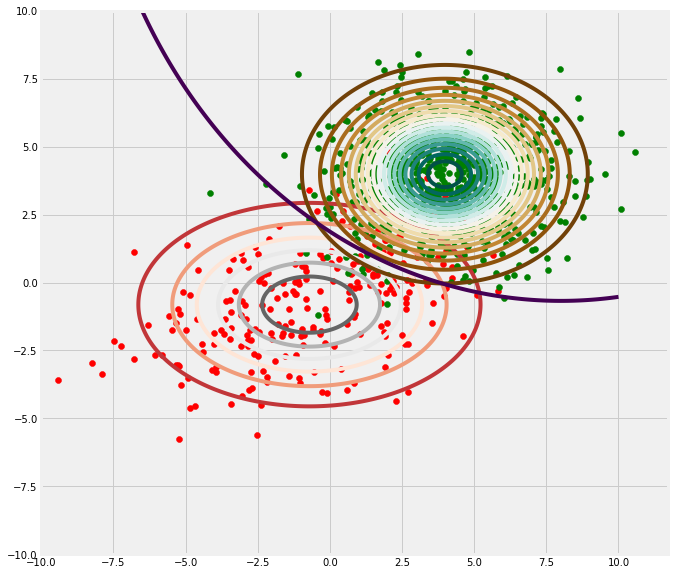

In [12]:
def plot_contour(sigma,mu,prior):     
    def g1(x, y):
        #probs=[np.log(prior[0])+compute_log_likelihood_optim(x=xi,mu=mu[0],sigma=sigma[0]) for xi in np.column_stack((x, y))]
        probs=np.log(prior[0])+compute_log_likelihood_optim(x=np.column_stack((x, y)),mu=mu[0],sigma=sigma[0])
        return np.array(probs)

    def g2(x, y):
        #probs=[np.log(prior[1])+compute_log_likelihood_optim(x=xi,mu=mu[1],sigma=sigma[1]) for xi in np.column_stack((x, y))]
        probs=np.log(prior[1])+compute_log_likelihood_optim(x=np.column_stack((x, y)),mu=mu[1],sigma=sigma[1])
        return np.array(probs)


    x = np.linspace(-10, 10, 500)
    y = np.linspace(-10, 10, 500)
    X, Y = np.meshgrid(x, y)

    pos = np.array([X.flatten(), Y.flatten()]).T

    # rv = multivariate_normal([mu_x, mu_y], [[variance_x, 0], [0, variance_y]])
    # rv1 = multivariate_normal(mu[0], sigma[0])
    # rv2 = multivariate_normal(mu[1], sigma[1])
    from time import time
    start=time()
    rv3=np.array(gaussian_density_optim(pos, mu[0], sigma[0]))
    rv4=np.array(gaussian_density_optim(pos, mu[1], sigma[1]))
    # X_train = np.r_[
    #     np.random.multivariate_normal(mu[0], sigma[0], size=500),
    #     np.random.multivariate_normal(mu[1], sigma[1], size=500),
    # ]
    # clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
    # clf.fit(X_train)

    fig = plt.figure(figsize=(10, 10))
    ax0 = fig.add_subplot(111)

    ax0.contour(X, Y, rv3.reshape(500, 500), cmap='RdGy')
    ax0.contour(X, Y, rv4.reshape(500, 500), 20, cmap='BrBG')
    x=X.flatten()
    y=Y.flatten()
    p = (g1(x, y) - g2(x, y)).reshape(X.shape)

    #scatter class 1
    ax0.scatter(data_c1[:,0], data_c1[:, 1],c="red")
    # scatter class 2
    ax0.scatter(data_c2[:, 0], data_c2[:, 1],c="green")

    ax0.contour(X, Y, p, levels=[0])

    plt.show()
    

plot_contour(sigma,mu,prior=prior)


Plotting the surface for class 1:

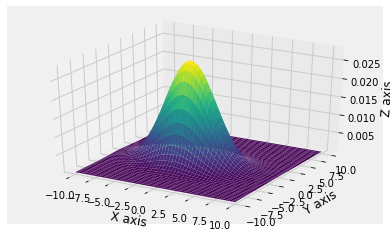

In [24]:

def plot_surface(X,sigma,mu):
       # Create grid and multivariate normal
    x = np.linspace(-10, 10, 500)
    y = np.linspace(-10, 10, 500)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    # compute gaussian probabilites for a 3D environment: 500x500x2 dimension
    rv = np.array([gaussian_density_optim(pos[i],mu=mu,sigma=sigma) for i in range(pos.shape[0])])

    # Make a 3D plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, rv, cmap='viridis', linewidth=0)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()
    
plot_surface(data_c1,sigma[0],mu[0])


Plotting the surface for class 2:

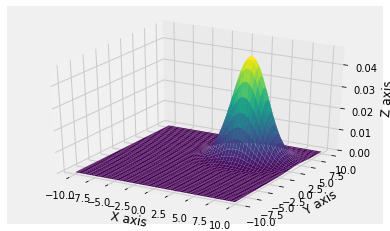

In [14]:
plot_surface(data_c2,sigma[1],mu[1])

Run predictions and compute the accuracy:

In [21]:
def predict(X,prior,mu, sigma):
    probs=[np.log(prior[c])+compute_log_likelihood_optim(X,sigma=sigma[c],mu=mu[c]) for c in range(len(prior))]
    # select class with highest probability
    y=np.argmax(probs,axis=0)
    return y



y_pred = predict(X, prior, mu, sigma)
print("Accuracy:",np.mean(Y==y_pred)*100, "%")

Accuracy: 94.6 %
